<H1>Testing inhibitory motifs</H1>

In [1]:
# loading python modules
import numpy as np
np.random.seed(0)

from matplotlib.pyplot import figure
from terminaltables import AsciiTable 

from __future__ import division

In [2]:
# loading custom inet modules
from inet import DataLoader
from inet.motifs import iicounter
from inet.utils import chem_squarematrix, elec_squarematrix

In [3]:
# use the dataset to create the null hypothesis
mydataset = DataLoader('../data/PV')

 161 syn  files loaded


<H2>Collect number of experiments </H2>

In [4]:
# e.g. mydataset.PV[2].values  will return the different configurations with 2 PV cells
nPV = range(9)
for i in nPV:
    nPV[i] = np.sum(mydataset.IN[i].values())
    nPV[i] = np.sum(mydataset.IN[i].values())

In [5]:
nPV

[0, 141, 18, 2, 0, 0, 0, 0, 0]

In [6]:
# for the moment, we only count experiments with 2 or 3 PVs
# later we use mydataset.PV[2:]
PV2 = sum(mydataset.IN[2].values())
PV3 = sum(mydataset.IN[3].values())
PV2, PV3

(18, 2)

<H2> Calculate empirical probabilities </H2>

In [7]:
PC = mydataset.motif.ii_chem_found/mydataset.motif.ii_chem_tested
PE = mydataset.motif.ii_elec_found/mydataset.motif.ii_elec_tested

PC2  = mydataset.motif.ii_c2_found/mydataset.motif.ii_c2_tested
Pdiv = mydataset.motif.ii_div_found/mydataset.motif.ii_div_tested

PC1E = mydataset.motif.ii_c1e_found/mydataset.motif.ii_c1e_tested
PC2E = mydataset.motif.ii_c2e_found/mydataset.motif.ii_c2e_tested



info = [
    ['key', 'Probability', 'Motif', 'Value'],
    ['ii_chem', 'P(C)', 'chemical synapse',PC ],
    ['ii_elec', 'P(E)', 'electrical synapse',PE ],
    ['','',''],
    ['ii_c2', 'P(C U C)','bidirectional chemical synapse',PC2],
    ['ii_div', 'Pdiv', 'divergent inhibitory motifs', Pdiv],
    ['',''],
    ['ii_c1e', 'P(C U E)', 'electrical and unidirectional chemical', PC1E],
    ['ii_c2e', 'P(2C U E):','electrical and bidirectional chemical', PC2E],

]
print(AsciiTable(info).table)

+---------+-------------+----------------------------------------+----------------+
| key     | Probability | Motif                                  | Value          |
+---------+-------------+----------------------------------------+----------------+
| ii_chem | P(C)        | chemical synapse                       | 0.291666666667 |
| ii_elec | P(E)        | electrical synapse                     | 0.458333333333 |
|         |             |                                        |                |
| ii_c2   | P(C U C)    | bidirectional chemical synapse         | 0.166666666667 |
| ii_div  | Pdiv        | divergent inhibitory motifs            | 0.166666666667 |
|         |             |                                        |                |
| ii_c1e  | P(C U E)    | electrical and unidirectional chemical | 0.145833333333 |
| ii_c2e  | P(2C U E):  | electrical and bidirectional chemical  | 0.125          |
+---------+-------------+----------------------------------------+----------

<H2> Simulate random chemical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.


In [8]:
def mychem_simulation():
    """
    simulate inhibitory chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(chem_squarematrix(size=2,prob = PC))

    for _ in range(PV3):
        mycount += iicounter(chem_squarematrix(size=3, prob = PC))
        
    return(mycount)

In [9]:
print(mychem_simulation()) # one simulation, test the number of connection tested

+----------+-------+--------+
| Motif    | found | tested |
+----------+-------+--------+
| ii_c1e   | 0     | 48     |
| ii_c2    | 2     | 24     |
| ii_c2e   | 0     | 24     |
| ii_chain | 1     | 6      |
| ii_chem  | 10    | 48     |
| ii_con   | 0     | 6      |
| ii_div   | 1     | 6      |
| ii_elec  | 0     | 24     |
+----------+-------+--------+



In [10]:
# must contain the same number of tested connections
for key in mychem_simulation().keys():
    print(key, mydataset.motif[key])

('ii_chem', {'tested': 48, 'found': 14})
('ii_c1e', {'tested': 48, 'found': 7})
('ii_div', {'tested': 6, 'found': 1})
('ii_c2e', {'tested': 24, 'found': 3})
('ii_elec', {'tested': 24, 'found': 11})
('ii_chain', {'tested': 6, 'found': 0})
('ii_con', {'tested': 6, 'found': 0})
('ii_c2', {'tested': 24, 'found': 4})


In [11]:
# simulate the whole data set 10,000 times
n_chem = list()
n_bichem = list()
n_div = list()

for _ in range(1000):
    syn_counter = mychem_simulation()
    n_chem.append(syn_counter['ii_chem']['found'])
    n_bichem.append(syn_counter['ii_c2']['found'])
    n_div.append(syn_counter['ii_div']['found'])

If the null hypothesis is correctly implemented, we should see almost the same 
number of chemical synases as in the experiments.

In [12]:
np.mean(n_chem) # on average 14 unidirectional connections


14.159000000000001

In [13]:
mydataset.motif['ii_chem']['found']

14

If we found a number which is different form the empirical, we must revise our 
null hypothese.

In [14]:
np.mean(n_bichem) # on average two

2.044

Define analiticaly the null hypothese:

In [15]:
PC*PC*mydataset.motif['ii_c2']['tested'] # null hypothesis

2.041666666666667

In [16]:
mydataset.motif['ii_c2']['found'] # however, we found more empirically

4

In [17]:
# Number of divergent connections found should be very similar to the ones calculates
np.mean(n_div)

0.498

In [18]:
PC*PC*mydataset.motif['ii_div']['tested']

0.5104166666666667

<H2> Simulate random electrical synapses</H2>
from a random distribution whose probability is adjusted to the empirical probability found in the recordings.

In [19]:
def myelec_simulation():
    """
    simulate inhibitory electrical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        mycount += iicounter(elec_squarematrix(size=2,prob = PE))

    for _ in range(PV3):
        mycount += iicounter(elec_squarematrix(size=3, prob = PE))
        
    return(mycount)

In [20]:
print(myelec_simulation()) # one simulation, test the number of connection tested

+----------+-------+--------+
| Motif    | found | tested |
+----------+-------+--------+
| ii_c1e   | 0     | 48     |
| ii_c2    | 0     | 24     |
| ii_c2e   | 0     | 24     |
| ii_chain | 0     | 6      |
| ii_chem  | 0     | 48     |
| ii_con   | 0     | 6      |
| ii_div   | 0     | 6      |
| ii_elec  | 11    | 24     |
+----------+-------+--------+



In [21]:
# must contain the same number of tested connections
for key in myelec_simulation().keys():
    print(key, mydataset.motif[key])

('ii_chem', {'tested': 48, 'found': 14})
('ii_c1e', {'tested': 48, 'found': 7})
('ii_div', {'tested': 6, 'found': 1})
('ii_c2e', {'tested': 24, 'found': 3})
('ii_elec', {'tested': 24, 'found': 11})
('ii_chain', {'tested': 6, 'found': 0})
('ii_con', {'tested': 6, 'found': 0})
('ii_c2', {'tested': 24, 'found': 4})


In [22]:
n_elec = list()
for _ in range(1000):
    syn_elec = myelec_simulation()
    n_elec.append(syn_elec['ii_elec']['found'])

Similarly, we must see almost the same 
number of electrical connections as with the experiments

In [23]:
np.mean(n_elec)

10.968

In [24]:
mydataset.motif.ii_elec_found # voila!

11

<H2>Simulate electrical and chemical synapses independently</H2>

In [25]:
C = chem_squarematrix(size = 2, prob = PC)
E = elec_squarematrix(size = 2, prob = PE)
C + E # when a chemical (1) and electrical (2) synapse add , they have the motif 3

array([[0, 0],
       [0, 0]])

In [26]:
def myii_simulation():
    """
    simulate inhibitory electrical and chemical connections of the dataset
    
    Return
    ------
    A iicounter object 
    """
    mycount = iicounter()
    for _ in range(PV2):
        C = chem_squarematrix(size = 2, prob = PC)
        E = elec_squarematrix(size = 2, prob = PE)
        
        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    for _ in range(PV3):
        C = chem_squarematrix(size = 3, prob = PC)
        E = elec_squarematrix(size = 3, prob = PE)

        S = C + E
        x, y = np.where(S==2) # test to eliminate '1' from the oposite direction
        mycoor = zip(y,x)
        for i,j in mycoor:
            if S[i,j]==1:
                S[i,j]=3
                S[j,i]=0
                
        mycount += iicounter( S ) 

    return(mycount)

In [27]:
myii_simulation()# one simulation, again, test the number of connections tested

{'ii_c1e': {'found': 6, 'tested': 48},
 'ii_c2': {'found': 4, 'tested': 24},
 'ii_c2e': {'found': 1, 'tested': 24},
 'ii_chain': {'found': 3, 'tested': 6},
 'ii_chem': {'found': 19, 'tested': 48},
 'ii_con': {'found': 1, 'tested': 6},
 'ii_div': {'found': 1, 'tested': 6},
 'ii_elec': {'found': 10, 'tested': 24}}

In [28]:
# must contain the same number of tested connections
for key in myii_simulation().keys():
    print(key, mydataset.motif[key])

('ii_chem', {'tested': 48, 'found': 14})
('ii_c1e', {'tested': 48, 'found': 7})
('ii_div', {'tested': 6, 'found': 1})
('ii_c2e', {'tested': 24, 'found': 3})
('ii_elec', {'tested': 24, 'found': 11})
('ii_chain', {'tested': 6, 'found': 0})
('ii_con', {'tested': 6, 'found': 0})
('ii_c2', {'tested': 24, 'found': 4})


In [29]:
# simulate the whole data set 1,000 times
n_chem = list()
n_elec = list()
n_c1e = list()
n_c2e = list()
n_c2 = list()

for _ in range(1000):
    syn_counter = myii_simulation()
    n_chem.append( syn_counter['ii_chem']['found'] )
    n_elec.append( syn_counter['ii_elec']['found'] )
    n_c1e.append( syn_counter['ii_c1e']['found'] )
    n_c2e.append( syn_counter['ii_c2e']['found'] )
    n_c2.append( syn_counter['ii_c2']['found'])

In [30]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical'], 
    ['chemical', np.mean(n_chem),  mydataset.motif['ii_chem']['found']],
    ['electrical', np.mean(n_elec),  mydataset.motif['ii_elec']['found']],
    ['','',''],
    ['2 chem',np.mean(n_c2),mydataset.motif['ii_c2']['found']],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif['ii_c1e']['found']],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif['ii_c2e']['found']],
     ]
print(AsciiTable(info).table)

+---------------+-------------+-----------+
| Syn Motif     | Simulations | Empirical |
+---------------+-------------+-----------+
| chemical      | 13.849      | 14        |
| electrical    | 10.911      | 11        |
|               |             |           |
| 2 chem        | 1.959       | 4         |
| 1 chem + elec | 6.319       | 7         |
| 2 chem + elec | 0.878       | 3         |
+---------------+-------------+-----------+


Let's see if the connections found correspond to the theoretical values for the complex motifs. 


<H3>ii_c2: bidirectional chemical connections</H3>

In [31]:
mydataset.motif['ii_c2']

{'found': 4, 'tested': 24}

In [32]:
PC1 = mydataset.motif.ii_chem_found /mydataset.motif.ii_chem_tested
PC1

0.2916666666666667

In [33]:
# definition of the null hypothese is based on unidirectional connections
(PC1*PC1)*mydataset.motif.ii_c2_tested # this value must be close to the simulation

2.041666666666667

<H3>ii_div: divergent inhibitory connections</H3>

In [34]:
mydataset.motif['ii_div']

{'found': 1, 'tested': 6}

In [35]:
Pdiv = mydataset.motif.ii_div_found /mydataset.motif.ii_div_tested
Pdiv

0.16666666666666666

In [36]:
# definition of the null hypothese is based on unidirectional connections
(PC1*PC1)*mydataset.motif.ii_div_tested # this value must be close to the simulation

0.5104166666666667

<H3>ce1: unidirectional chemical connections in the presence of an electrical synapse</H3>

In [37]:
mydataset.motif['ii_c1e']

{'found': 7, 'tested': 48}

In [38]:
PCE1 = mydataset.motif.ii_c1e_found /mydataset.motif.ii_c1e_tested
PCE1

0.14583333333333334

In [39]:
# definition of the null hypothese
(PC*PE)*mydataset.motif.ii_c1e_tested # this value must be close to the simulation

6.416666666666666

<H3>ce2: bidirectional chemical connections in the presence of an electrical synapse</H3>

In [40]:
mydataset.motif['ii_c2e']

{'found': 3, 'tested': 24}

In [41]:
PCE2 = mydataset.motif.ii_c2e_found /mydataset.motif.ii_c2e_tested
PCE2

0.125

In [42]:
(PE*PC*PC)*mydataset.motif.ii_c2e_tested # this value must be close to the simulation

0.9357638888888891

<H2>Calculating P-Values</H2>

In [43]:
n_chem = np.array(n_chem)
n_elec = np.array(n_elec)
n_c1e = np.array(n_c1e)
n_c2e = np.array(n_c2e)
n_c2 = np.array(n_c2)
n_div = np.array(n_div)


In [44]:
pii_chem = len(n_chem[n_chem>mydataset.motif.ii_chem_found]) / n_chem.size
pii_elec = len(n_elec[n_elec>mydataset.motif.ii_elec_found])/ n_elec.size
pii_c1e = len(n_c1e[n_c1e>mydataset.motif.ii_c1e_found])/ n_c1e.size
pii_c2e = len(n_c2e[n_c2e>mydataset.motif.ii_c2e_found])/ n_c2e.size
pii_c2 =  len(n_c2[n_c2e>mydataset.motif.ii_c2_found])/ n_c2.size
pii_div = len(n_div[n_div>mydataset.motif.ii_div_found])/n_div.size

In [45]:
info = [
    ['Syn Motif', 'Simulations', 'Empirical', 'P(Simulations)'], 
    ['chemical', np.mean(n_chem),  mydataset.motif.ii_chem_found, pii_chem],
    ['electrical', np.mean(n_elec),  mydataset.motif.ii_elec_found, pii_elec],
    [''],
    ['2 chem bidirect', np.mean(n_c2),  mydataset.motif.ii_c2_found, pii_c2],
    ['divergent', np.mean(n_div), mydataset.motif.ii_div_found, pii_div],
    [''],
    ['1 chem + elec', np.mean(n_c1e),  mydataset.motif.ii_c1e_found, pii_c1e],
    ['2 chem + elec', np.mean(n_c2e),  mydataset.motif.ii_c2e_found, pii_c2e],
     ]
print(AsciiTable(info).table)

+-----------------+-------------+-----------+----------------+
| Syn Motif       | Simulations | Empirical | P(Simulations) |
+-----------------+-------------+-----------+----------------+
| chemical        | 13.849      | 14        | 0.417          |
| electrical      | 10.911      | 11        | 0.412          |
|                 |             |           |                |
| 2 chem bidirect | 1.959       | 4         | 0.0            |
| divergent       | 0.498       | 1         | 0.094          |
|                 |             |           |                |
| 1 chem + elec   | 6.319       | 7         | 0.305          |
| 2 chem + elec   | 0.878       | 3         | 0.004          |
+-----------------+-------------+-----------+----------------+


In [46]:
from inet.plots import barplot

<H2> Plot chemical synapses alone</H2>

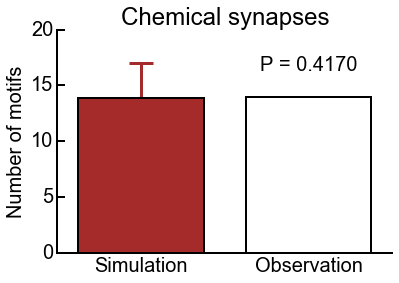

In [47]:
fig = figure(1)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_chem, n_found = mydataset.motif.ii_chem_found);
ax.set_title('Chemical synapses');
ax.set_ylim(ymax=20);

fig.savefig('ii_chem.pdf')

<H2>Plot electrical synapses alone </H2>

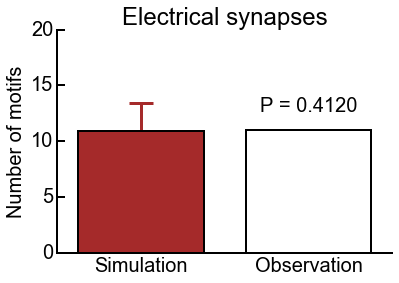

In [48]:
fig = figure(2)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_elec, n_found = mydataset.motif.ii_elec_found);
ax.set_title('Electrical synapses');
ax.set_ylim(ymax=20);

fig.savefig('ii_elec.pdf')

<H2>Plot bidirectional chemical synapses</H2>


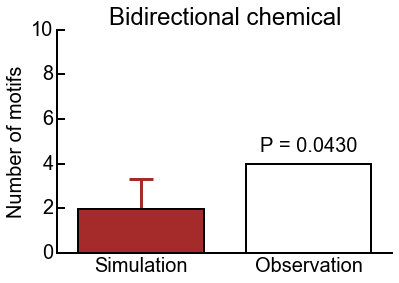

In [49]:
fig = figure(4)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2, n_found = mydataset.motif.ii_c2_found);
ax.set_title('Bidirectional chemical');
ax.set_ylim(ymax=10);

fig.savefig('ii_c2.pdf')

<H2>Plot electrical and one chemical synapse alone </H2>

<H2> Plot divergent inhibitory </H2>

(0, 5)

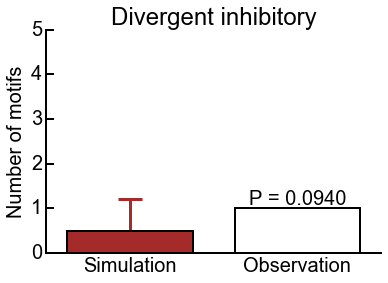

In [50]:
fig = figure()
ax = fig.add_subplot(111)

ax = barplot(simulation = n_div, n_found = mydataset.motif.ii_div_found);
ax.set_title('Divergent inhibitory');
ax.set_ylim(ymin=0, ymax=5);

#fig.savefig('ii_c1e.pdf')

(0.0, 10)

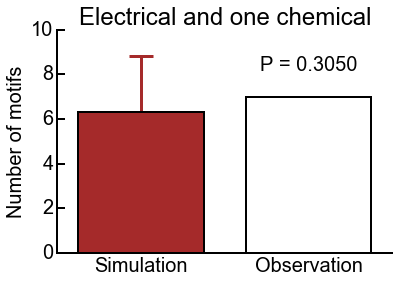

In [51]:
fig = figure(4)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c1e, n_found = mydataset.motif.ii_c1e_found);
ax.set_title('Electrical and one chemical');
ax.set_ylim(ymax=10);

#fig.savefig('ii_c1e.pdf')

<H2>Plot electrical and two chemical</H2>

(0, 5)

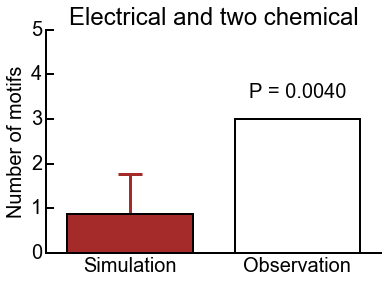

In [52]:
fig = figure(5)
ax = fig.add_subplot(111)

ax = barplot(simulation = n_c2e, n_found = mydataset.motif.ii_c2e_found);
ax.set_title('Electrical and two chemical');
ax.set_ylim(ymin  = 0, ymax=5);

#fig.savefig('ii_c2d.pdf')